# Exercise 4

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [12]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    if use_cuda:
        torch.cuda.is_available()
        device = "cuda"
    else:
        device = "cpu"

    loss_fn = nn.NLLLoss()

    # TODO: set the model to train mode
    model.train()
    
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for idx, (x,y) in enumerate(train_loader):
        x.to(device)
        y.to(device)

        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        output = model(x)
        
        # TODO: compute negative log likelihood loss
        batch_loss = loss_fn(output, y)
        
        # TODO: do backpropagation
        batch_loss.backward()
        
        # TODO: optimize
        optimizer.step()
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if idx % log_interval == 0:
            print("Epoch: " + str(epoch) + " Loss: " + str(batch_loss.item()))
        

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [5]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet3"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [ ]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        super(FCNet1, self).__init__()#
        self.activation = nn.Sigmoid()
        self.linear1 = nn.Linear(784, 200)
        self.linear2 = nn.Linear(200, 100)
        self.linear3 = nn.Linear(100, 60)
        self.linear4 = nn.Linear(60, 30)
        self.linear5 = nn.Linear(30, 10)
        self.softmax = nn.LogSoftmax(dim=1)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        # original shape: (64, 1, 28, 28) should be (64, 784)
        x = x.view(x.size(0), -1)  # Flattens each image while preserving batch size
        
        # TODO: run network layers
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.activation(x)
        x = self.linear4(x)
        x = self.activation(x)
        x = self.linear5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = self.softmax(x)

        return output

In [24]:
class FCNet2(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with relu non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        # TODO: initialize network layers
        super(FCNet2, self).__init__()#
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(784, 200)
        self.linear2 = nn.Linear(200, 100)
        self.linear3 = nn.Linear(100, 60)
        self.linear4 = nn.Linear(60, 30)
        self.linear5 = nn.Linear(30, 10)
        self.softmax = nn.LogSoftmax(dim=1)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        # original shape: (64, 1, 28, 28) should be (64, 784)
        x = x.view(x.size(0), -1)  # Flattens each image while preserving batch size
        
        # TODO: run network layers
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.activation(x)
        x = self.linear4(x)
        x = self.activation(x)
        x = self.linear5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = self.softmax(x)

        return output

In [26]:
class FCNet3(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with relu non-linearity and batch normalisation
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        # TODO: initialize network layers
        super(FCNet3, self).__init__()#
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(784, 200)
        self.batchNorm1 = nn.BatchNorm1d(200)
        self.linear2 = nn.Linear(200, 100)
        self.linear3 = nn.Linear(100, 60)
        self.batchNorm3 = nn.BatchNorm1d(60)
        self.linear4 = nn.Linear(60, 30)
        self.linear5 = nn.Linear(30, 10)
        self.softmax = nn.LogSoftmax(dim=1)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        # original shape: (64, 1, 28, 28) should be (64, 784)
        x = x.view(x.size(0), -1)  # Flattens each image while preserving batch size
        
        # TODO: run network layers
        x = self.linear1(x)
        x = self.batchNorm1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.batchNorm3(x)
        x = self.activation(x)
        x = self.linear4(x)
        x = self.activation(x)
        x = self.linear5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = self.softmax(x)

        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [ ]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # TODO: initialize network layers
        

    def forward(self, x):
        # TODO: run convolutional layers
        
        
        # TODO: reshape batch of images to batch of 1D vectors
        
        
        # TODO: run fully connected layers
       
        
        # TODO: compute log softmax over the output
        
        
        return output

In [ ]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()

    def forward(self, x):
        pass

In [ ]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()

    def forward(self, x):
        pass

Epoch: 1 Loss: 2.3135673999786377
Epoch: 1 Loss: 0.5867051482200623
Epoch: 1 Loss: 0.15832741558551788
Epoch: 1 Loss: 0.22786496579647064
Epoch: 1 Loss: 0.15985357761383057
Epoch: 1 Loss: 0.1633911430835724
Epoch: 1 Loss: 0.32439500093460083
Epoch: 1 Loss: 0.06454938650131226
Epoch: 1 Loss: 0.2092464417219162
Epoch: 1 Loss: 0.16464635729789734

Test set: Average loss: 0.1254, Accuracy: 9615/10000 (96.15%)



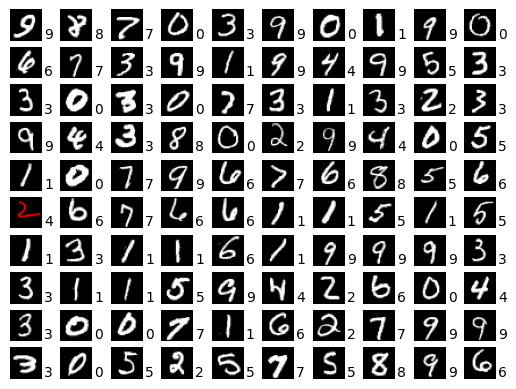

Epoch: 2 Loss: 0.10313187539577484
Epoch: 2 Loss: 0.015030032023787498
Epoch: 2 Loss: 0.09260151535272598
Epoch: 2 Loss: 0.08828055113554001
Epoch: 2 Loss: 0.04155068099498749
Epoch: 2 Loss: 0.0533883310854435
Epoch: 2 Loss: 0.04917879402637482
Epoch: 2 Loss: 0.08823232352733612
Epoch: 2 Loss: 0.0639960989356041
Epoch: 2 Loss: 0.0613156259059906

Test set: Average loss: 0.1039, Accuracy: 9702/10000 (97.02%)



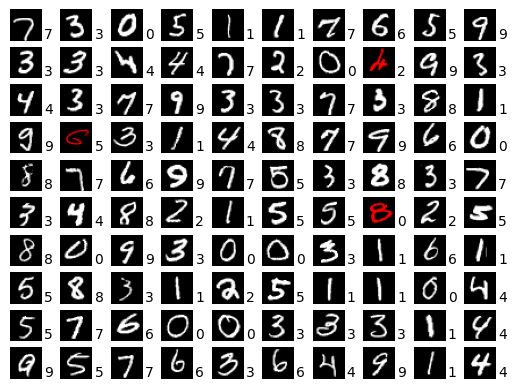

Epoch: 3 Loss: 0.010767062194645405
Epoch: 3 Loss: 0.05614861845970154
Epoch: 3 Loss: 0.03323918953537941
Epoch: 3 Loss: 0.009953498840332031
Epoch: 3 Loss: 0.1569555103778839
Epoch: 3 Loss: 0.014634106308221817
Epoch: 3 Loss: 0.028955938294529915
Epoch: 3 Loss: 0.005017569288611412
Epoch: 3 Loss: 0.040267907083034515
Epoch: 3 Loss: 0.029901666566729546

Test set: Average loss: 0.0896, Accuracy: 9755/10000 (97.55%)



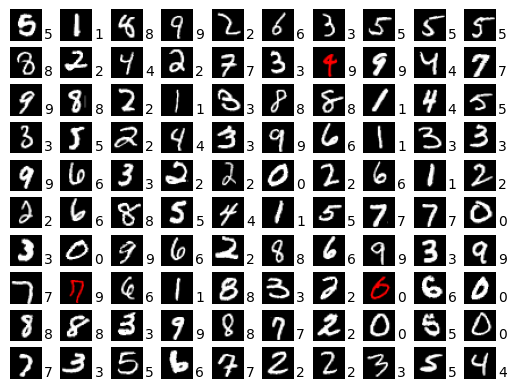

Epoch: 4 Loss: 0.07540614157915115
Epoch: 4 Loss: 0.006310066673904657
Epoch: 4 Loss: 0.12419247627258301
Epoch: 4 Loss: 0.004867178853601217
Epoch: 4 Loss: 0.008768746629357338
Epoch: 4 Loss: 0.02455410361289978
Epoch: 4 Loss: 0.011064606718719006
Epoch: 4 Loss: 0.017210159450769424
Epoch: 4 Loss: 0.004172829445451498
Epoch: 4 Loss: 0.016935044899582863

Test set: Average loss: 0.0747, Accuracy: 9802/10000 (98.02%)



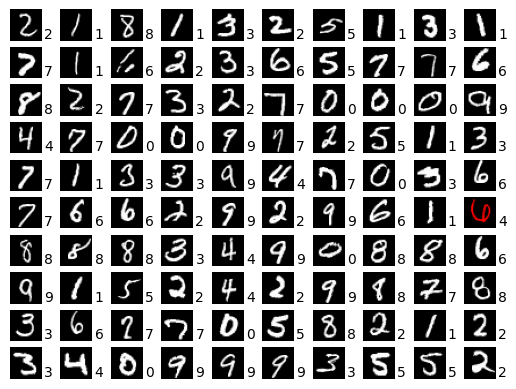

Epoch: 5 Loss: 0.0011630631051957607
Epoch: 5 Loss: 0.06754200905561447
Epoch: 5 Loss: 0.017368828877806664
Epoch: 5 Loss: 0.0014863504329696298
Epoch: 5 Loss: 0.0056008328683674335
Epoch: 5 Loss: 0.06970752030611038
Epoch: 5 Loss: 0.08919122815132141
Epoch: 5 Loss: 0.011088378727436066
Epoch: 5 Loss: 0.009582470171153545
Epoch: 5 Loss: 0.0003712944162543863

Test set: Average loss: 0.0815, Accuracy: 9802/10000 (98.02%)



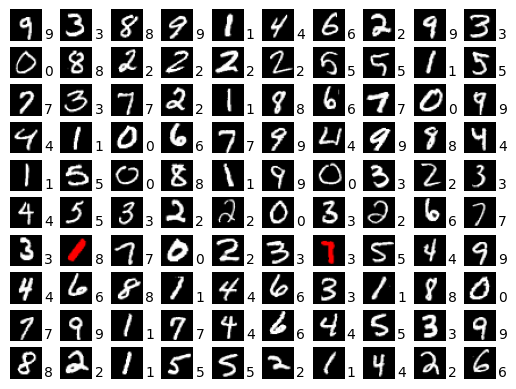

Epoch: 6 Loss: 0.0006570076802745461
Epoch: 6 Loss: 0.008489890955388546
Epoch: 6 Loss: 0.007142196875065565
Epoch: 6 Loss: 0.0003485121997073293
Epoch: 6 Loss: 0.001733036246150732
Epoch: 6 Loss: 0.0012330617755651474
Epoch: 6 Loss: 0.0013353172689676285
Epoch: 6 Loss: 0.04200886934995651
Epoch: 6 Loss: 0.003079082351177931
Epoch: 6 Loss: 0.0003754524514079094

Test set: Average loss: 0.0770, Accuracy: 9825/10000 (98.25%)



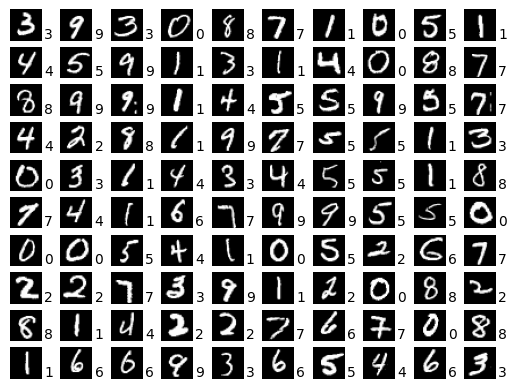

Epoch: 7 Loss: 0.00019936979515478015
Epoch: 7 Loss: 0.0017459194641560316
Epoch: 7 Loss: 0.0015028093475848436
Epoch: 7 Loss: 0.0017811664147302508
Epoch: 7 Loss: 0.003773240139707923
Epoch: 7 Loss: 0.0001465555396862328
Epoch: 7 Loss: 0.003043803386390209
Epoch: 7 Loss: 0.06551755964756012
Epoch: 7 Loss: 0.00038540089735761285
Epoch: 7 Loss: 0.02885238640010357

Test set: Average loss: 0.0821, Accuracy: 9821/10000 (98.21%)



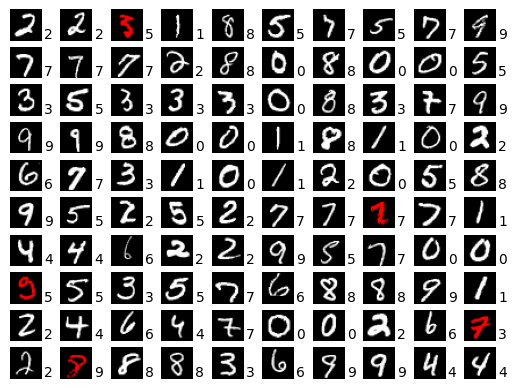

Epoch: 8 Loss: 0.002271918347105384
Epoch: 8 Loss: 0.01942634955048561
Epoch: 8 Loss: 0.00042531907092779875
Epoch: 8 Loss: 0.0005185374757274985
Epoch: 8 Loss: 0.001372446888126433
Epoch: 8 Loss: 0.002692608628422022
Epoch: 8 Loss: 0.0028287528548389673
Epoch: 8 Loss: 0.0010291856015101075
Epoch: 8 Loss: 0.06871252506971359
Epoch: 8 Loss: 0.00010278137779096141

Test set: Average loss: 0.0831, Accuracy: 9829/10000 (98.29%)



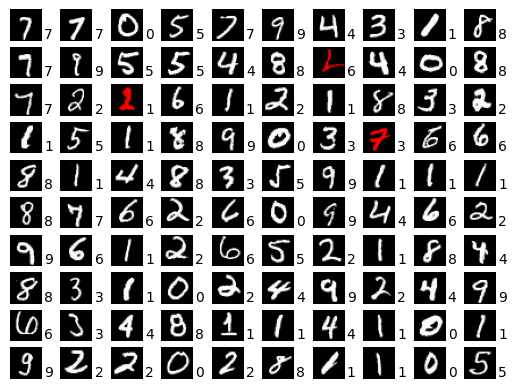

Epoch: 9 Loss: 0.002009338466450572
Epoch: 9 Loss: 0.0009688768186606467
Epoch: 9 Loss: 0.05977199599146843
Epoch: 9 Loss: 0.0012204983504489064
Epoch: 9 Loss: 0.04033086821436882
Epoch: 9 Loss: 0.0016017132438719273
Epoch: 9 Loss: 0.00046877682325430214
Epoch: 9 Loss: 0.00036572414683178067
Epoch: 9 Loss: 0.001056293142028153
Epoch: 9 Loss: 0.03239522501826286

Test set: Average loss: 0.0854, Accuracy: 9822/10000 (98.22%)



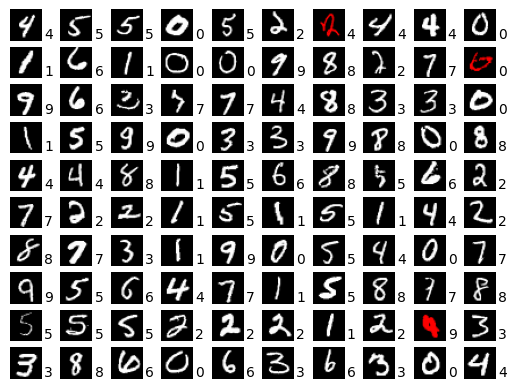

Epoch: 10 Loss: 0.058594319969415665
Epoch: 10 Loss: 0.0006885336479172111
Epoch: 10 Loss: 0.0013407104415819049
Epoch: 10 Loss: 0.0003045738267246634
Epoch: 10 Loss: 0.0009875362738966942
Epoch: 10 Loss: 0.00018157096928916872
Epoch: 10 Loss: 0.003415143582969904
Epoch: 10 Loss: 1.2391204109007958e-05
Epoch: 10 Loss: 0.0013179330853745341
Epoch: 10 Loss: 0.0008510141633450985

Test set: Average loss: 0.0864, Accuracy: 9820/10000 (98.20%)



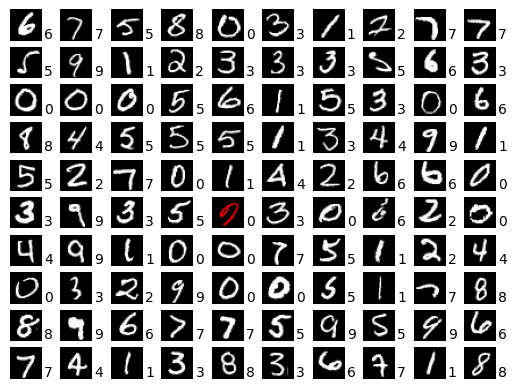

In [ ]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")